In [3]:
# March 26, 2024
# location of this script: /glade/u/home/sglanvil/analysis/python/analysis/grid_NCEP.ipynb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pygrib
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp1d

file = "/glade/derecho/scratch/sglanvil/holdingCell/cdas1.t00z.pgrbhanl.nc" # first, I converted it to netcdf
ds = xr.open_dataset(file)
input_variables = {}
input_variables = {
    'U': ds.UGRD_P0_L100_GLL0,
    'V': ds.VGRD_P0_L100_GLL0,
    'US': ds.UGRD_P0_L100_GLL0,
    'VS': ds.VGRD_P0_L100_GLL0,
    'T': ds.TMP_P0_L100_GLL0,
    'Q': ds.SPFH_P0_L100_GLL0,
    'PS': ds.PRES_P0_L1_GLL0,
    'PHIS': ds.HGT_P0_L1_GLL0,
    'lon': ds.lon_0,
    'lat': ds.lat_0,
    'lev': ds.lv_ISBL0/100   # note the original data is in Pa
}

# --- file to pull hyai, hybi, hyam, hybm info to define OUTPUT levels
file_lev = "/glade/campaign/cesm/development/cross-wg/S2S/CESM2/CAMI/CFSv2/CESM2_NCEP_0.9x1.25_L32.cam2.i.2023-12-01-00000.nc"
ds = xr.open_dataset(file_lev, decode_times=False)
jerry_variables = {}
for var_name, var_data in ds.variables.items():
    jerry_variables[var_name] = np.squeeze(var_data)

# --- flip the lat dimension because it currently goes from 90 to -90...
for var_name, var_data in input_variables.items():
    if var_data.ndim == 2:
        var_data = var_data[::-1, :]
    if var_data.ndim == 3:
        var_data = var_data[:, ::-1, :]
    if var_name == 'lat':
        var_data = var_data[::-1]
    input_variables[var_name] = var_data

# --- horizontal interpolation
output_variables = {}
for var_name, var_data in input_variables.items():
    output_variables[var_name] = []
    if var_data.ndim == 2:
        interpolator = RectBivariateSpline(input_variables['lat'],
                                           input_variables['lon'],
                                           input_variables[var_name][:, :])
        output_variables[var_name] = interpolator(jerry_variables['lat'],
                                                  jerry_variables['lon'])
    if var_data.ndim == 3:
        latType = 'lat'
        lonType = 'lon'
        if var_name == 'US':
            latType = 'slat'
        if var_name == 'VS':
            lonType = 'slon'
        new_data_list = []
        for level in range(input_variables[var_name].shape[0]):
            interpolator = RectBivariateSpline(input_variables['lat'], 
                                               input_variables['lon'], 
                                               input_variables[var_name][level, :, :])
            new_data = interpolator(jerry_variables[latType], 
                                    jerry_variables[lonType]) 
            new_data_list.append(new_data)
        output_variables[var_name] = np.array(new_data_list)
    if var_data.ndim == 1:
        output_variables[var_name] = jerry_variables[var_name]

# vertical interpolation
final_variables = {}
for var_name, var_data in output_variables.items():
    print(var_name) 
    final_variables[var_name] = []
    if var_data.ndim == 3:
        latType = 'lat'
        lonType = 'lon'
        if var_name == 'US':
            latType = 'slat'
        if var_name == 'VS':
            lonType = 'slon'
        interpolated_data = np.zeros((len(jerry_variables['lev']),
                                      len(jerry_variables[latType]),
                                      len(jerry_variables[lonType])))
        for i in range(len(jerry_variables[latType])):
            for j in range(len(jerry_variables[lonType])):
                f = interp1d(input_variables['lev'],
                             output_variables[var_name][:, i, j],
                             kind='nearest', fill_value='extrapolate')
                interpolated_data[:, i, j] = f(jerry_variables['lev'])
        final_variables[var_name] = interpolated_data
    if var_data.ndim < 3:
        final_variables[var_name] = output_variables[var_name]

final_variables['slat']=jerry_variables['slat']
final_variables['slon']=jerry_variables['slon']
final_variables['ilev']=jerry_variables['ilev']
final_variables['hyai']=jerry_variables['hyai']
final_variables['hybi']=jerry_variables['hybi']
final_variables['hyam']=jerry_variables['hyam']
final_variables['hybm']=jerry_variables['hybm']
final_variables['P0']=jerry_variables['P0']

# ---------- NEXT STEPS
# handle the metadata (esp time) such that CESM can read it properly??
# maybe hard-code the metadata stuff (reducing to bare minimum)
# Question: do we need time dimension such that U(time,lev,lat,lon) and such?

U
V
US
VS
T
Q
PS
PHIS
lon
lat
lev


In [4]:
ds = xr.Dataset()
for var_name, var_data in final_variables.items():
    print(var_name)
    if len(var_data.shape) == 3:
        latType = 'lat'
        lonType = 'lon'
        if var_name == 'US':
            latType = 'slat'
        if var_name == 'VS':
            lonType = 'slon'
        dims = ('lev', latType, lonType)
        ds[var_name] = xr.DataArray(var_data, dims=dims)
    if len(var_data.shape) == 2:
        dims = ('lat', 'lon')
        ds[var_name] = xr.DataArray(var_data, dims=dims)
    if len(var_data.shape) <= 1:
        ds[var_name] = var_data
    # if var_name == 'P0'
    #     ds[var_name] = var_data
    ds[var_name].attrs = jerry_variables[var_name].attrs
ds.to_netcdf("/glade/u/home/sglanvil/analysis/python/analysis/output.nc")


U
V
US
VS
T
Q
PS
PHIS
lon
lat
lev
slat
slon
ilev
hyai
hybi
hyam
hybm
P0


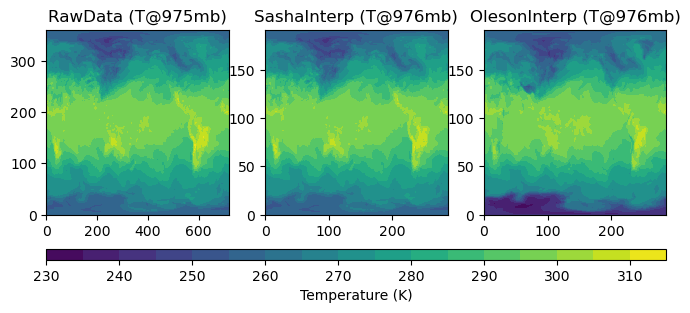

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3))  # 1 row, 3 columns
cmap = 'viridis'  # Example colormap
contour_levels = np.arange(230, 320, 5)
im0 = axs[0].contourf(input_variables['T'][35, :, :],
                      cmap=cmap,
                      levels=contour_levels)
axs[0].set_title('RawData (T@975mb)')

im1 = axs[1].contourf(final_variables['T'][30, :, :],
                      cmap=cmap,
                      levels=contour_levels)
axs[1].set_title('SashaInterp (T@976mb)')

im2 = axs[2].contourf(jerry_variables['T'][30, :, :],
                      cmap=cmap,
                      levels=contour_levels)
axs[2].set_title('OlesonInterp (T@976mb)')

cbar = fig.colorbar(im2, ax=axs, orientation='horizontal',
                    pad=0.15, fraction=0.05, aspect=60)
cbar.set_label('Temperature (K)')  


In [38]:
print(input_variables['lev'].values[35])
print(final_variables['lev'].values[30])
print(jerry_variables['lev'].values[30])

975.0
976.325407391414
976.325407391414


In [ ]:
# other notes

# ...if you need to make these coordinates by hand...
# lat = np.linspace(-90, 90, 192)
# lon = np.linspace(0, 360, 289)[:-1]
# slat = lat[:-1] + np.diff(lat)/2
# slon1 = 0 - np.unique(np.diff(lon)/2)
# slon2 = lon[:-1] + np.diff(lon)/2
# slon = np.concatenate((slon1, slon2))

# Yeager's version: /glade/campaign/cesm/development/espwg/JRA55_regridded_to_CAM/tools

# for var in ds.variables:
#     print(var)